# **Cat Vs Dog Classification**

### **Importing Libraries**

In [1]:
import os
import shutil
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### **0. Setting/Paths**

In [ ]:
original_dir = pathlib.Path("cleaned_dataset")
base_dir = pathlib.Path("cats_vs_dogs_split")
os.makedirs(base_dir, exist_ok=True)

### **1. Utility: make dataset subsets**

In [ ]:
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            src = original_dir / fname
            if src.exists():  # Ensure file exists before copying
                shutil.copyfile(src, dir / fname)

In [ ]:
make_subset("train", start_index=0, end_index=8831)  
make_subset("validation", start_index=8831, end_index=9935)  
make_subset("test", start_index=9935, end_index=11039)

# **Building the model**

### **Listing 8.7 Instantiating a small convnet for dogs vs. cats classification**

In [5]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

### **Listing 8.8 Configuring the model for training**

In [6]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### **Listing 8.9 Using image_dataset_from_directory to read images**

In [7]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 17662 files belonging to 2 classes.
Found 2208 files belonging to 2 classes.
Found 1799 files belonging to 2 classes.


### **Listing 8.10 Displaying the shapes of the data and labels yielded by the Dataset**

In [8]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


### **Listing 8.11 Fitting the model using a Dataset**

Callbacks

In [9]:
callbacks = [
keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch.keras",
    save_best_only=True,
    monitor="val_loss")
]

Train baseline

In [10]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
552/552 [==============================] - 24s 41ms/step - loss: 0.6721 - accuracy: 0.6151 - val_loss: 0.5767 - val_accuracy: 0.7006
Epoch 2/30
552/552 [==============================] - 18s 33ms/step - loss: 0.5207 - accuracy: 0.7482 - val_loss: 0.4178 - val_accuracy: 0.8034
Epoch 3/30
552/552 [==============================] - 18s 33ms/step - loss: 0.4336 - accuracy: 0.8019 - val_loss: 0.4467 - val_accuracy: 0.7899
Epoch 4/30
552/552 [==============================] - 18s 33ms/step - loss: 0.3613 - accuracy: 0.8414 - val_loss: 0.3671 - val_accuracy: 0.8460
Epoch 5/30
552/552 [==============================] - 18s 33ms/step - loss: 0.2995 - accuracy: 0.8710 - val_loss: 0.3354 - val_accuracy: 0.8605
Epoch 6/30
552/552 [==============================] - 18s 33ms/step - loss: 0.2447 - accuracy: 0.8994 - val_loss: 0.3735 - val_accuracy: 0.8433
Epoch 7/30
552/552 [==============================] - 18s 33ms/step - loss: 0.1951 - accuracy: 0.9225 - val_loss: 0.4877 - val_accuracy:

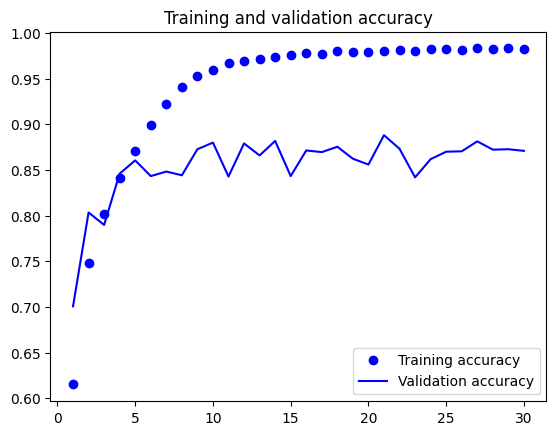

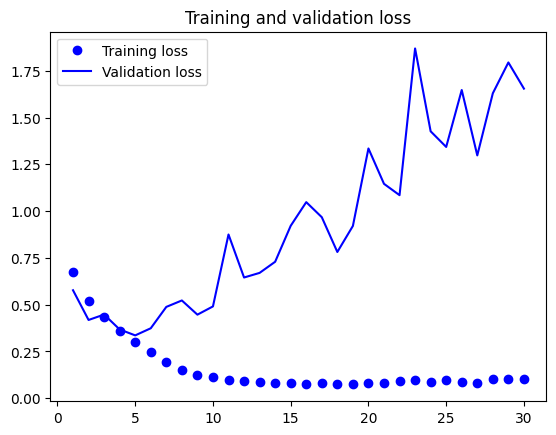

In [11]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Evaluate saved best model

In [12]:
best_scratch = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = best_scratch.evaluate(test_dataset)
print(f"[Scratch model] Test accuracy: {test_acc:.3f}")

57/57 [==============================] - 2s 29ms/step - loss: 0.3427 - accuracy: 0.8660
[Scratch model] Test accuracy: 0.866


# **Using data augmentation**

### **Listing 8.14 Define a data augmentation stage to add to an image model**

In [13]:
# If you want a cleaner output without the warning spam, you can suppress them with:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [14]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

### **Listing 8.15 Displaying some randomly augmented training images**

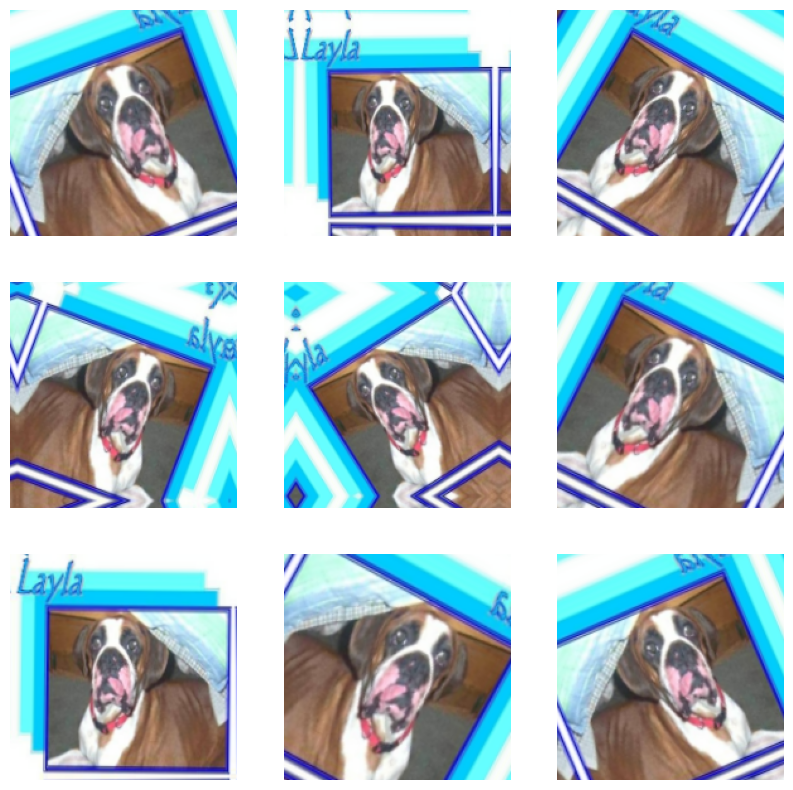

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### **Listing 8.16 Defining a new convnet that includes image augmentation and dropout**

In [16]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                           

### **Listing 8.17 Training the regularized convnet**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch_with_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50


552/552 [==============================] - 84s 152ms/step - loss: 0.6573 - accuracy: 0.6067 - val_loss: 0.5945 - val_accuracy: 0.6707
Epoch 2/50
552/552 [==============================] - 86s 156ms/step - loss: 0.5745 - accuracy: 0.7054 - val_loss: 0.5599 - val_accuracy: 0.7278
Epoch 3/50
552/552 [==============================] - 86s 155ms/step - loss: 0.5157 - accuracy: 0.7530 - val_loss: 0.4587 - val_accuracy: 0.7853
Epoch 4/50
552/552 [==============================] - 84s 152ms/step - loss: 0.4675 - accuracy: 0.7822 - val_loss: 0.3970 - val_accuracy: 0.8247
Epoch 5/50
552/552 [==============================] - 85s 154ms/step - loss: 0.4290 - accuracy: 0.8065 - val_loss: 0.4094 - val_accuracy: 0.8157
Epoch 6/50
552/552 [==============================] - 87s 157ms/step - loss: 0.4017 - accuracy: 0.8193 - val_loss: 0.4942 - val_accuracy: 0.8157
Epoch 7/50
552/552 [==============================] - 86s 156ms/step - loss: 0.3761 - accuracy: 0.8365 - val_loss: 0.3175 - val_accuracy: 0.8

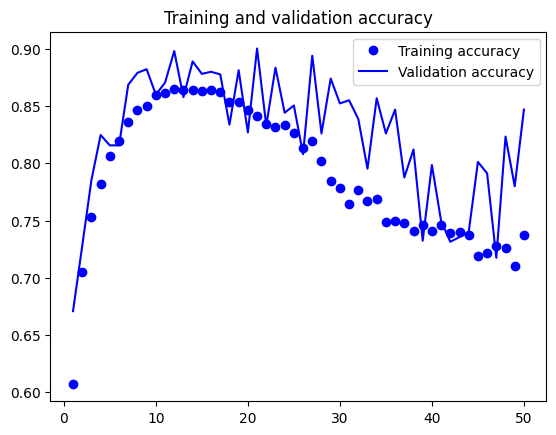

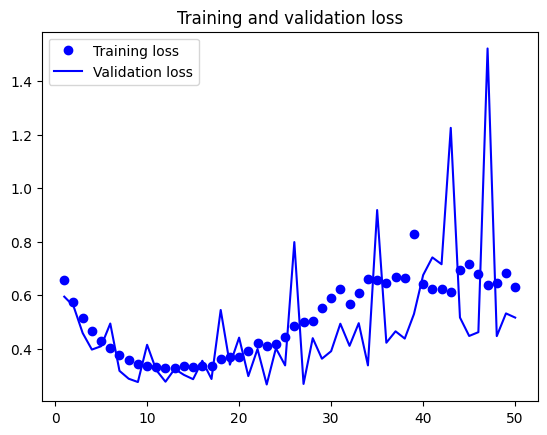

In [19]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [20]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

57/57 [==============================] - 1s 16ms/step - loss: 0.2816 - accuracy: 0.8783
Test accuracy: 0.878


# **Leveraging a pretrained model**

### **Feature extraction with a pretrained model**

### **5. Transfer learning: VGG16 as conv_base (feature extraction)**

In [21]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

### **Extracting the VGG16 features and corresponding labels**

Memory-safe feature extraction function

In [22]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 1s 668ms/step


In [23]:
print("Feature shapes:", train_features.shape, val_features.shape, test_features.shape)

Feature shapes: (17662, 5, 5, 512) (2208, 5, 5, 512) (1799, 5, 5, 512)


### **Listing 8.21 Defining and training the densely connected classifier**

In [24]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [25]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [26]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
552/552 [==============================] - 3s 5ms/step - loss: 8.4646 - accuracy: 0.9586 - val_loss: 9.3121 - val_accuracy: 0.9493
Epoch 2/20
552/552 [==============================] - 3s 5ms/step - loss: 2.7715 - accuracy: 0.9780 - val_loss: 4.6914 - val_accuracy: 0.9678
Epoch 3/20
552/552 [==============================] - 3s 5ms/step - loss: 1.4855 - accuracy: 0.9827 - val_loss: 3.4544 - val_accuracy: 0.9755
Epoch 4/20
552/552 [==============================] - 3s 5ms/step - loss: 1.0186 - accuracy: 0.9865 - val_loss: 3.2019 - val_accuracy: 0.9751
Epoch 5/20
552/552 [==============================] - 3s 5ms/step - loss: 0.6969 - accuracy: 0.9891 - val_loss: 2.8332 - val_accuracy: 0.9755
Epoch 6/20
552/552 [==============================] - 3s 5ms/step - loss: 0.5711 - accuracy: 0.9911 - val_loss: 4.0291 - val_accuracy: 0.9683
Epoch 7/20
552/552 [==============================] - 3s 5ms/step - loss: 0.4735 - accuracy: 0.9916 - val_loss: 3.6471 - val_accuracy: 0.9742
Epoch 

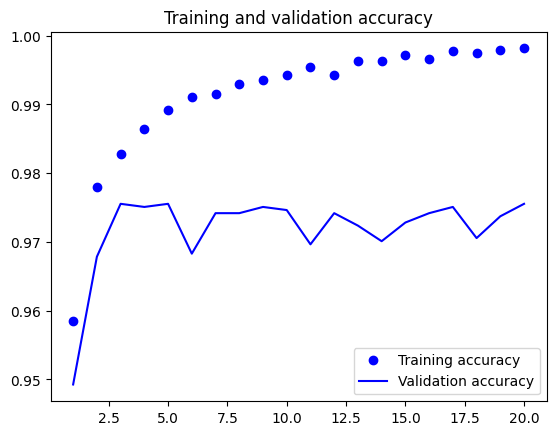

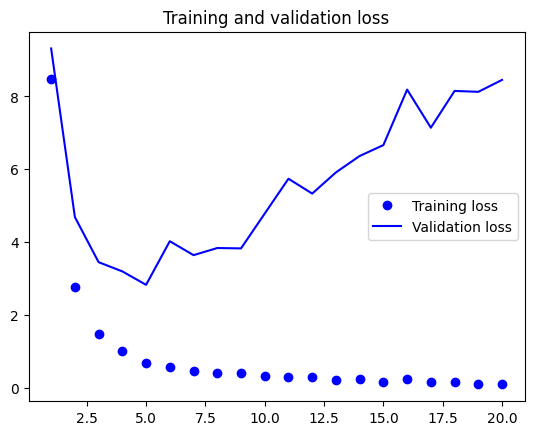

In [27]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## **FEATURE EXTRACTION TOGETHER WITH DATA AUGMENTATION**

### **Listing 8.23 Instantiating and freezing the VGG16 convolutional base**

In [28]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

### **Listing 8.24 Printing the list of trainable weights before and after freezing**

In [29]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [30]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


Now we can create a new model that chains together

 - A data augmentation stage
 - Our frozen convolutional base
 - A dense classifier

### **Listing 8.25 Adding a data augmentation stage and a classifier to the convolutional base**

In [31]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [34]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction_with_data_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10


552/552 [==============================] - 99s 179ms/step - loss: 0.8386 - accuracy: 0.9705 - val_loss: 1.3646 - val_accuracy: 0.9742
Epoch 2/10
552/552 [==============================] - 98s 178ms/step - loss: 0.8184 - accuracy: 0.9719 - val_loss: 1.4531 - val_accuracy: 0.9787
Epoch 3/10
552/552 [==============================] - 98s 178ms/step - loss: 0.8974 - accuracy: 0.9693 - val_loss: 1.1819 - val_accuracy: 0.9737
Epoch 4/10
552/552 [==============================] - 97s 176ms/step - loss: 0.7870 - accuracy: 0.9742 - val_loss: 2.1980 - val_accuracy: 0.9597
Epoch 5/10
552/552 [==============================] - 97s 176ms/step - loss: 0.8765 - accuracy: 0.9729 - val_loss: 1.5297 - val_accuracy: 0.9746
Epoch 6/10
552/552 [==============================] - 97s 176ms/step - loss: 0.9311 - accuracy: 0.9723 - val_loss: 1.6137 - val_accuracy: 0.9742
Epoch 7/10
552/552 [==============================] - 98s 177ms/step - loss: 0.9025 - accuracy: 0.9728 - val_loss: 1.8405 - val_accuracy: 0.9

### **Listing 8.26 Evaluating the model on the test set**

In [36]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

57/57 [==============================] - 4s 60ms/step - loss: 0.9880 - accuracy: 0.9844
Test accuracy: 0.984


# **Fine-tuning a pretrained model**

### **Listing 8.27 Freezing all layers until the fourth from the last**

In [37]:
# Build combined model: data augmentation + preprocess + conv_base + GAP + classifier
conv_base.trainable = True
# Freeze all layers except the last 4 layers
for layer in conv_base.layers[:-4]:
    layer.trainable = False

### **Listing 8.28 Fine-tuning the model**

In [38]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

In [39]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="fine_tuning.keras",
    save_best_only=True,
    monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
552/552 [==============================] - 109s 194ms/step - loss: 0.9024 - accuracy: 0.9584 - val_loss: 0.6432 - val_accuracy: 0.9656
Epoch 2/30
552/552 [==============================] - 106s 192ms/step - loss: 0.2900 - accuracy: 0.9511 - val_loss: 0.3010 - val_accuracy: 0.9606
Epoch 3/30
552/552 [==============================] - 105s 189ms/step - loss: 0.1541 - accuracy: 0.9569 - val_loss: 0.2556 - val_accuracy: 0.9678
Epoch 4/30
552/552 [==============================] - 103s 187ms/step - loss: 0.1093 - accuracy: 0.9703 - val_loss: 0.2244 - val_accuracy: 0.9715
Epoch 5/30
552/552 [==============================] - 103s 187ms/step - loss: 0.0864 - accuracy: 0.9761 - val_loss: 0.2316 - val_accuracy: 0.9733
Epoch 6/30
552/552 [==============================] - 103s 187ms/step - loss: 0.0802 - accuracy: 0.9784 - val_loss: 0.1727 - val_accuracy: 0.9751
Epoch 7/30
552/552 [==============================] - 103s 187ms/step - loss: 0.0629 - accuracy: 0.9814 - val_loss: 0.2132 -

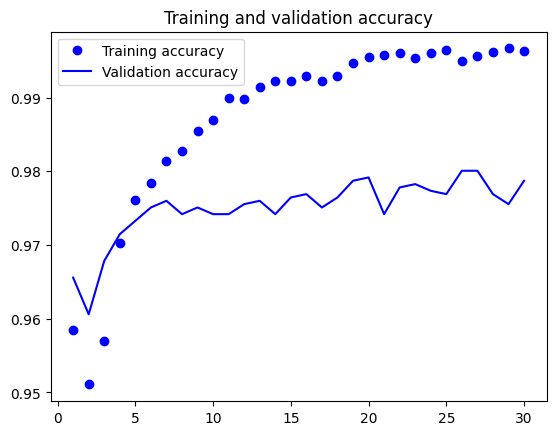

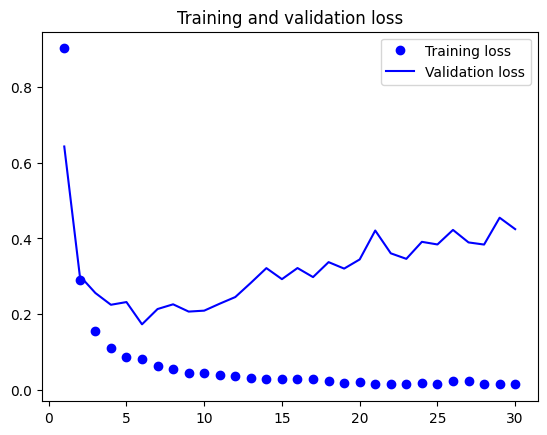

In [40]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Evaluate final best fine-tuned model

In [41]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

57/57 [==============================] - 4s 60ms/step - loss: 0.1199 - accuracy: 0.9822
Test accuracy: 0.982


### **Visualize some predictions from best model**

In [42]:
test_dataset = pathlib.Path("D:/Zafir Project/Cat And Dog Classification/practices/cats_vs_dogs_split/test")

In [43]:
# Load dataset from directory
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dataset,
    image_size=(180, 180),
    batch_size=32,
    shuffle=False
)

Found 1799 files belonging to 2 classes.


In [44]:
sample_ds = test_ds.unbatch().batch(32)

1/1 [==============================] - 0s 90ms/step


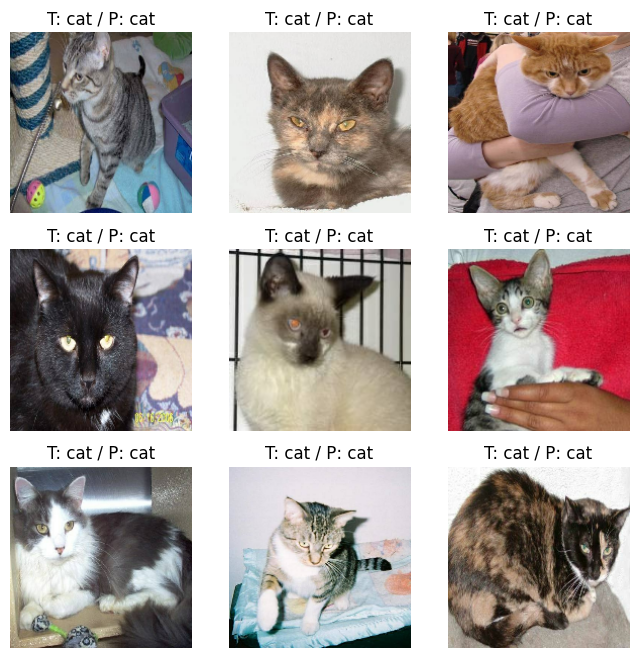

In [45]:
def show_sample_predictions(model, sample_ds, class_names=("cat","dog"), n=9):
    plt.figure(figsize=(8,8))
    for images, labels in sample_ds.take(1):
        preds = model.predict(images)
        preds = (preds > 0.5).astype("int32").flatten()
        for i in range(n):
            ax = plt.subplot(3,3,i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            true = class_names[int(labels[i].numpy())]
            pred = class_names[int(preds[i])]
            plt.title(f"T: {true} / P: {pred}")
            plt.axis("off")
    plt.show()

show_sample_predictions(model, sample_ds, class_names=("cat","dog"), n=9)